In [2]:
pip install git+https://github.com/dbouget/raidionics_rads_lib.git

  Cloning https://github.com/dbouget/raidionics_rads_lib.git to /home/dbouget/.tmp/pip-req-build-e2k9rh18
  Running command git clone --filter=blob:none --quiet https://github.com/dbouget/raidionics_rads_lib.git /home/dbouget/.tmp/pip-req-build-e2k9rh18
  Resolved https://github.com/dbouget/raidionics_rads_lib.git to commit 99a051cffb75d3f83c2b10d8bbbc21b93024f108
  Running command git submodule update --init --recursive -q
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/dbouget/raidionics_seg_lib.git (to revision master) to /home/dbouget/.tmp/pip-install-jp26ftt5/raidionicsseg_309133eb556f431da9fbe18b3179dedc
  Running command git clone --filter=blob:none --quiet https://github.com/dbouget/raidionics_seg_lib.git /home/dbouget/.tmp/pip-install-jp26ftt5/raidionicsseg_309133eb556f431da9fbe18b3179dedc
  Resolved https://github.com/dbouget/raidionics_seg_lib.git to commit 3d9d150426d8cae17ff8636fe3fe662693a37391
  Preparing metadata (setup.py) ... done
Note: you may n

In [2]:
# Download test data
import os
import requests
import zipfile

test_dir = os.path.join(os.getcwd(), 'unit_tests_results_dir')
os.makedirs(test_dir, exist_ok=True)
patient_dir = os.path.join(test_dir, 'patient')
results_dir = os.path.join(test_dir, 'results')
models_dir = os.path.join(test_dir, 'models')
os.makedirs(patient_dir, exist_ok=True)
os.makedirs(results_dir, exist_ok=True)
os.makedirs(models_dir, exist_ok=True)

test_image_url = 'https://github.com/raidionics/Raidionics-models/releases/download/1.2.0/Samples-RaidionicsRADSLib-UnitTest1.zip'
seq_model_url = 'https://github.com/raidionics/Raidionics-models/releases/download/1.2.0/Raidionics-MRI_Sequence_Classifier-ONNX-v12.zip'
brain_model_url = 'https://github.com/raidionics/Raidionics-models/releases/download/1.2.0/Raidionics-MRI_Brain-ONNX-v12.zip'
tumor_model_url = 'https://github.com/raidionics/Raidionics-models/releases/download/1.2.0/Raidionics-MRI_GBM-ONNX-v12.zip'

archive_dl_dest = os.path.join(test_dir, 'inference_patient.zip')
if not os.path.exists(archive_dl_dest):
    headers = {}
    response = requests.get(test_image_url, headers=headers, stream=True)
    response.raise_for_status()
    if response.status_code == requests.codes.ok:
        with open(archive_dl_dest, "wb") as f:
            for chunk in response.iter_content(chunk_size=1048576):
                f.write(chunk)
    with zipfile.ZipFile(archive_dl_dest, 'r') as zip_ref:
        zip_ref.extractall(test_dir)

archive_dl_dest = os.path.join(test_dir, 'seq-model.zip')
if not os.path.exists(archive_dl_dest):
    headers = {}
    response = requests.get(seq_model_url, headers=headers, stream=True)
    response.raise_for_status()
    if response.status_code == requests.codes.ok:
        with open(archive_dl_dest, "wb") as f:
            for chunk in response.iter_content(chunk_size=1048576):
                f.write(chunk)
    with zipfile.ZipFile(archive_dl_dest, 'r') as zip_ref:
        zip_ref.extractall(models_dir)

archive_dl_dest = os.path.join(test_dir, 'brain-model.zip')
if not os.path.exists(archive_dl_dest):
    headers = {}
    response = requests.get(brain_model_url, headers=headers, stream=True)
    response.raise_for_status()
    if response.status_code == requests.codes.ok:
        with open(archive_dl_dest, "wb") as f:
            for chunk in response.iter_content(chunk_size=1048576):
                f.write(chunk)
    with zipfile.ZipFile(archive_dl_dest, 'r') as zip_ref:
        zip_ref.extractall(models_dir)
            
archive_dl_dest = os.path.join(test_dir, 'tumor-model.zip')
if not os.path.exists(archive_dl_dest):
    headers = {}
    response = requests.get(tumor_model_url, headers=headers, stream=True)
    response.raise_for_status()
    if response.status_code == requests.codes.ok:
        with open(archive_dl_dest, "wb") as f:
            for chunk in response.iter_content(chunk_size=1048576):
                f.write(chunk)
    with zipfile.ZipFile(archive_dl_dest, 'r') as zip_ref:
        zip_ref.extractall(models_dir)


assert(os.path.exists(os.path.join(patient_dir, 'T0')))
assert(os.path.exists(os.path.join(models_dir, 'MRI_Sequence_Classifier')))
assert(os.path.exists(os.path.join(models_dir, 'MRI_Brain')))
assert(os.path.exists(os.path.join(models_dir, 'MRI_GBM')))

In [3]:
# Prepare the configuration file
import configparser
import json
import logging

logging.basicConfig()
logging.getLogger().setLevel(logging.DEBUG)

rads_config = configparser.ConfigParser()
rads_config.add_section('Default')
rads_config.set('Default', 'task', 'neuro_diagnosis')
rads_config.set('Default', 'caller', '')
rads_config.add_section('System')
rads_config.set('System', 'gpu_id', "-1")
rads_config.set('System', 'input_folder', patient_dir)
rads_config.set('System', 'output_folder', results_dir)
rads_config.set('System', 'model_folder', models_dir)
rads_config.set('System', 'pipeline_filename', os.path.join(test_dir, 'test_pipeline.json'))
rads_config.add_section('Runtime')
rads_config.set('Runtime', 'reconstruction_method', 'thresholding')
rads_config.set('Runtime', 'reconstruction_order', 'resample_first')
rads_config.add_section('Neuro')
# The cortical features can be computed from the following atlases: [MNI, Schaefer7, Schaefer17, Harvard-Oxford]
rads_config.set('Neuro', 'cortical_features', 'MNI, Schaefer17')
## Computing the following is quite time-consuming
# rads_config.set('Neuro', 'subcortical_features', 'BCB')
rads_config_filename = os.path.join(results_dir, 'rads_config.ini')
with open(rads_config_filename, 'w') as outfile:
    rads_config.write(outfile)

# Preparing the underlying pipeline
pipeline_json = {}
step_index = 1
step_str = str(step_index)
pipeline_json[step_str] = {}
pipeline_json[step_str]["task"] = "Classification"
pipeline_json[step_str]["inputs"] = {}  # Empty input means running it on all existing data for the patient
pipeline_json[step_str]["model"] = "MRI_Sequence_Classifier"
pipeline_json[step_str]["description"] = "Classification of the MRI sequence type for all input scans."

step_index = step_index + 1
step_str = str(step_index)
pipeline_json[step_str] = {}
pipeline_json[step_str]["task"] = "Segmentation"
pipeline_json[step_str]["inputs"] = {}
pipeline_json[step_str]["inputs"]["0"] = {}
pipeline_json[step_str]["inputs"]["0"]["timestamp"] = 0
pipeline_json[step_str]["inputs"]["0"]["sequence"] = "T1-CE"
pipeline_json[step_str]["inputs"]["0"]["labels"] = None
pipeline_json[step_str]["inputs"]["0"]["space"] = {}
pipeline_json[step_str]["inputs"]["0"]["space"]["timestamp"] = 0
pipeline_json[step_str]["inputs"]["0"]["space"]["sequence"] = "T1-CE"
pipeline_json[step_str]["target"] = "Brain"
pipeline_json[step_str]["model"] = "MRI_Brain"
pipeline_json[step_str]["description"] = "Brain segmentation in T1-CE (T0)."

step_index = step_index + 1
step_str = str(step_index)
pipeline_json[step_str] = {}
pipeline_json[step_str]["task"] = "Segmentation"
pipeline_json[step_str]["inputs"] = {}
pipeline_json[step_str]["inputs"]["0"] = {}
pipeline_json[step_str]["inputs"]["0"]["timestamp"] = 0
pipeline_json[step_str]["inputs"]["0"]["sequence"] = "T1-CE"
pipeline_json[step_str]["inputs"]["0"]["labels"] = None
pipeline_json[step_str]["inputs"]["0"]["space"] = {}
pipeline_json[step_str]["inputs"]["0"]["space"]["timestamp"] = 0
pipeline_json[step_str]["inputs"]["0"]["space"]["sequence"] = "T1-CE"
pipeline_json[step_str]["target"] = "Tumor"
pipeline_json[step_str]["model"] = "MRI_GBM"
pipeline_json[step_str]["description"] = "Tumor segmentation in T1-CE (T0)."

step_index = step_index + 1
step_str = str(step_index)
pipeline_json[step_str] = {}
pipeline_json[step_str]["task"] = "Registration"
pipeline_json[step_str]["moving"] = {}
pipeline_json[step_str]["moving"]["timestamp"] = 0
pipeline_json[step_str]["moving"]["sequence"] = "T1-CE"
pipeline_json[step_str]["fixed"] = {}
pipeline_json[step_str]["fixed"]["timestamp"] = -1
pipeline_json[step_str]["fixed"]["sequence"] = "MNI"
pipeline_json[step_str]["description"] = "Registration T1-CE (T0) to MNI."

step_index = step_index + 1
step_str = str(step_index)
pipeline_json[step_str] = {}
pipeline_json[step_str]["task"] = "Apply registration"
pipeline_json[step_str]["moving"] = {}
pipeline_json[step_str]["moving"]["timestamp"] = 0
pipeline_json[step_str]["moving"]["sequence"] = "T1-CE"
pipeline_json[step_str]["fixed"] = {}
pipeline_json[step_str]["fixed"]["timestamp"] = -1
pipeline_json[step_str]["fixed"]["sequence"] = "MNI"
pipeline_json[step_str]["direction"] = "forward"
pipeline_json[step_str]["description"] = "Apply registration from T1-CE (T0) to MNI."

step_index = step_index + 1
step_str = str(step_index)
pipeline_json[step_str] = {}
pipeline_json[step_str]["task"] = "Apply registration"
pipeline_json[step_str]["moving"] = {}
pipeline_json[step_str]["moving"]["timestamp"] = 0
pipeline_json[step_str]["moving"]["sequence"] = "T1-CE"
pipeline_json[step_str]["fixed"] = {}
pipeline_json[step_str]["fixed"]["timestamp"] = -1
pipeline_json[step_str]["fixed"]["sequence"] = "MNI"
pipeline_json[step_str]["direction"] = "inverse"
pipeline_json[step_str]["description"] = "Apply inverse registration from MNI to T1-CE (T0)."

step_index = step_index + 1
step_str = str(step_index)
pipeline_json[step_str] = {}
pipeline_json[step_str]["task"] = "Features computation"
pipeline_json[step_str]["input"] = {}
pipeline_json[step_str]["input"]["timestamp"] = 0
pipeline_json[step_str]["input"]["sequence"] = "T1-CE"
pipeline_json[step_str]["target"] = "Tumor"
pipeline_json[step_str]["space"] = "MNI"
pipeline_json[step_str]["description"] = "Tumor features computation from T1-CE (T0) in MNI space."

with open(os.path.join(test_dir, 'test_pipeline.json'), 'w', newline='\n') as outfile:
    json.dump(pipeline_json, outfile, indent=4, sort_keys=True)

# Running the reporting task
from raidionicsrads.compute import run_rads
run_rads(rads_config_filename)

INFO:root:Starting pipeline for file: /home/dbouget/Code/Private/raidionics_rads_lib/notebooks/unit_tests_results_dir/test_pipeline.json.
INFO:root:LOG: Pipeline - 7 steps.
INFO:root:LOG: Pipeline - Classification of the MRI sequence type for all input scans. - Begin (1/7)
INFO:root:Starting inference for folder: inputs, with model: /home/dbouget/Code/Private/raidionics_rads_lib/notebooks/unit_tests_results_dir/models/MRI_Sequence_Classifier.
INFO:root:LOG: Classification - 3 steps.
INFO:root:LOG: Classification - Preprocessing - Begin (1/3)
DEBUG:root:Preprocessing - Extracting input data.
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
DEBUG:root:Preprocessing - Resampling.
DEBUG:root:Preprocessing - Background clipping.
DEBUG:root:MRI background cropping with: [14, 18, 46, 194, 222, 228].

DEBUG:root:Preprocessing - Volume resizing.
DEBUG:root:Preprocessing - Intensity normalization.


In [15]:
# Inspecting the text-readable generated report
report_filename = os.path.join(results_dir, 'neuro_clinical_report.txt')
with open(report_filename, 'r') as file:
    content = file.read()
    print(content)

########### Raidionics clinical report ###########
Tumor type: Glioblastoma
Tumor multifocality: False
  * Number tumor parts: 1
  * Largest distance between components: -1.0 (mm)

Volumes
  * MNI space: 2.67 (ml)

Laterality
  * Left hemisphere: 100.0%
  * Right hemisphere: 0.0%
  * Midline crossing: False

Resectability
  * Expected residual volume: 0.23 (ml)
  * Resection index: 0.913

Cortical structures overlap
  * MNI atlas
    - frontal left: 98.09%
    - extracerebral-csf nan: 1.91%
  * Schaefer17 atlas
    - salienceventralattentiona: 54.97%
    - somatomotora: 16.31%
    - salienceventralattentionb: 14.55%
    - somatomotorbauditory: 0.41%

Subcortical structures overlap or distance



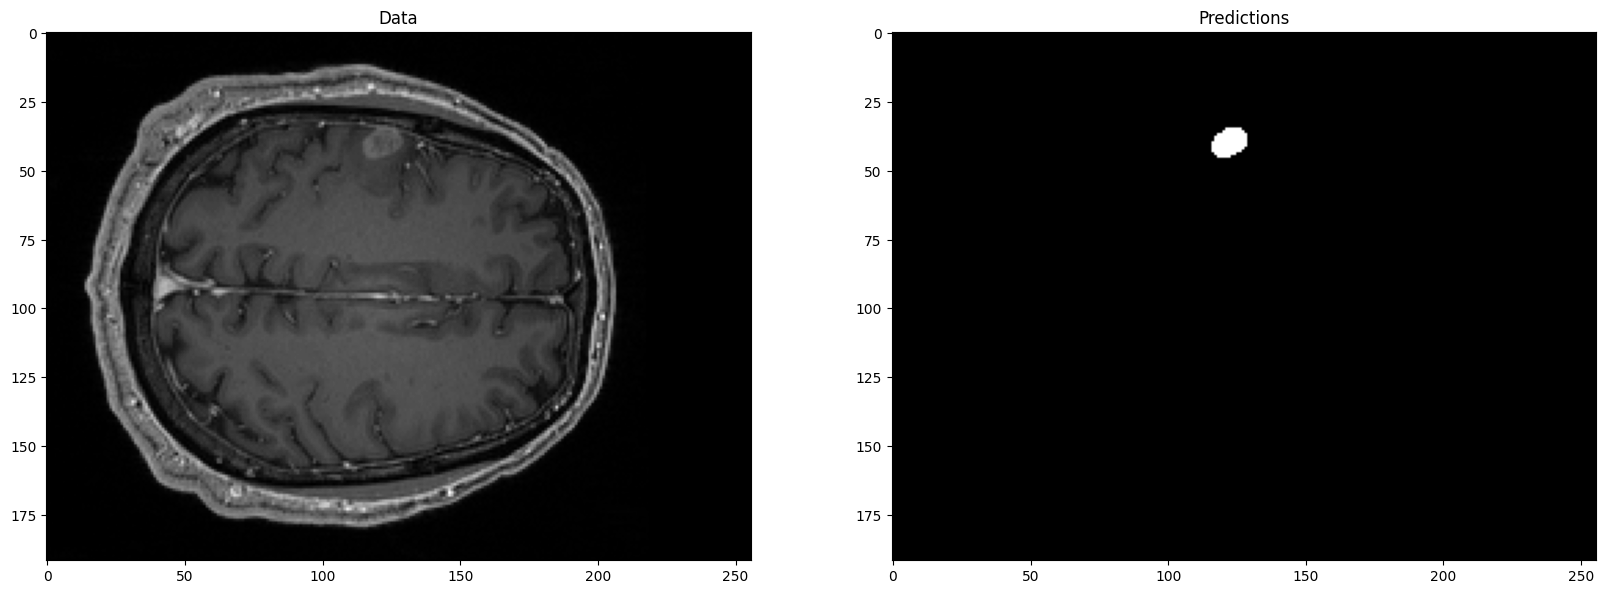

In [16]:
# Inspect the tumor segmentation 
import nibabel as nib
import matplotlib.pyplot as plt

logging.getLogger().setLevel(logging.WARNING)
data_filename = os.path.join(patient_dir, 'T0', 'input1.nii.gz')
predictions_filename = os.path.join(results_dir, 'T0', 'input1_annotation-Tumor.nii.gz')

data = nib.load(data_filename).get_fdata()[:]
predictions = nib.load(predictions_filename).get_fdata()[:]

predictions[predictions < 0.5] = 0
predictions[predictions >= 0.5] = 1

# plot corresponding data and predictions for a single 2D slice
slice_nr = 170
fig, ax = plt.subplots(1, 2, figsize=(20, 12))
ax[0].imshow(data[..., slice_nr], cmap="gray")
ax[1].imshow(predictions[..., slice_nr], cmap="gray")

for i, title in enumerate(["Data", "Predictions"]):
  ax[i].set_title(title)
plt.show()

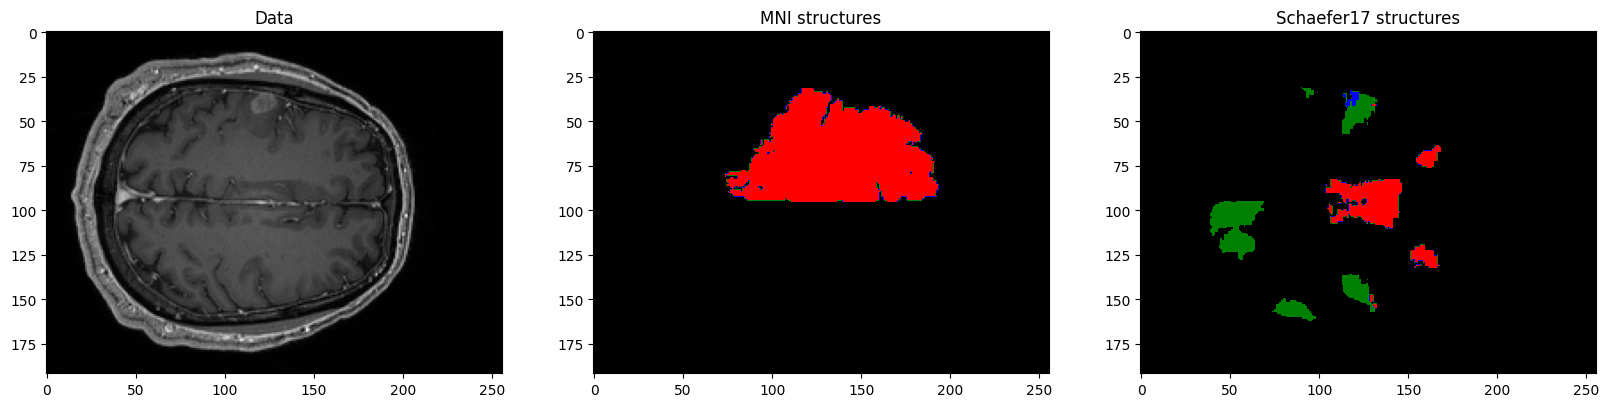

In [24]:
# Inspecting the results
import nibabel as nib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

logging.getLogger().setLevel(logging.WARNING)

# Loading the results
data_filename = os.path.join(patient_dir, 'T0', 'input1.nii.gz')
mni_cortical_filename = os.path.join(results_dir, 'T0', 'Cortical-structures', 'MNI_MNI_atlas.nii.gz')
mni_cortical_desc_filename = os.path.join(results_dir, 'atlas_descriptions', 'MNI_description.csv')
schaefer17_cortical_filename = os.path.join(results_dir, 'T0', 'Cortical-structures', 'MNI_Schaefer17_atlas.nii.gz')
schaefer17_cortical_desc_filename = os.path.join(results_dir, 'atlas_descriptions', 'Schaefer17_description.csv')

data = nib.load(data_filename).get_fdata()[:]
mni_cortical = nib.load(mni_cortical_filename).get_fdata()[:]
schaefer17_cortical = nib.load(schaefer17_cortical_filename).get_fdata()[:]
mni_description = pd.read_csv(mni_cortical_desc_filename)
schaefer17_description = pd.read_csv(schaefer17_cortical_desc_filename)

# Querying indexes for the cortical structures overlapping with the tumor based on the generated text report.
mni_struct_indexes = [mni_description.loc[mni_description['text'] == 'frontal_left_gm']['label'].values[0], mni_description.loc[mni_description['text'] == 'frontal_left_wm']['label'].values[0]]
schaefer17_struct_indexes = [schaefer17_description.loc[schaefer17_description['text'] == 'salienceVentralAttentionA']['label'].values[0], schaefer17_description.loc[schaefer17_description['text'] == 'somatomotorA']['label'].values[0], schaefer17_description.loc[schaefer17_description['text'] == 'salienceVentralAttentionB']['label'].values[0]]
relevant_mni_struct = np.zeros(mni_cortical.shape)
relevant_mni_struct[mni_cortical == mni_struct_indexes[0]] = 1
relevant_mni_struct[mni_cortical == mni_struct_indexes[1]] = 1

relevant_schaefer17_struct = np.zeros(schaefer17_cortical.shape)
for i, s in enumerate(schaefer17_struct_indexes):
    relevant_schaefer17_struct[schaefer17_cortical == s] = i + 1


colors = ['black','green','blue','red']
cmap = matplotlib.colors.ListedColormap(colors)

# plot corresponding data and predictions for a single 2D slice
slice_nr = 170
fig, ax = plt.subplots(1, 3, figsize=(20, 12))
ax[0].imshow(data[..., slice_nr], cmap="gray")
ax[1].imshow(relevant_mni_struct[..., slice_nr], cmap=cmap)
ax[2].imshow(relevant_schaefer17_struct[..., slice_nr], cmap=cmap)

for i, title in enumerate(["Data", "MNI structures", "Schaefer17 structures"]):
  ax[i].set_title(title)
plt.show()

In [39]:
# Inspecting the full extent of computed features
import pandas as pd

report_filename = os.path.join(results_dir, 'neuro_clinical_report.csv')
report_df = pd.read_csv(report_filename)

column_names = list(report_df.columns)

# Multifocality
features = report_df.values[0, 0:3]
print("Multifocality features ({} elements):\n {}\n\n".format(len(features), list(zip(column_names[0:3], features))))

# Volumes
features = report_df.values[0, 3:5]
print("Volume features ({} elements):\n {}\n\n".format(len(features), list(zip(column_names[3:5], features))))

# Laterality
features = report_df.values[0, 5:8]
print("Laterality features ({} elements):\n {}\n\n".format(len(features), list(zip(column_names[5:8], features))))

# Resectability
features = report_df.values[0, 8:10]
print("Resectability features ({} elements):\n {}\n\n".format(len(features), list(zip(column_names[8:10], features))))

# MNI cortical structures
features = report_df.values[0, 10:38]
print("MNI cortical structures features ({} elements):\n {}\n\n".format(len(features), list(zip(column_names[10:38], features))))

# Schaefer17 cortical structures
features = report_df.values[0, 38:]
print("Schaefer17 cortical structures features ({} elements):\n {}\n\n".format(len(features), list(zip(column_names[38:], features))))

Multifocality features (3 elements):
 [('Multifocality', False), ('Tumor parts nb', 1), ('Multifocal distance (mm)', -1.0)]


Volume features (2 elements):
 [('Volume original (ml)', nan), ('Volume in MNI (ml)', 2.67)]


Laterality features (3 elements):
 [('Left laterality (%)', 100.0), ('Right laterality (%)', 0.0), ('Midline crossing', False)]


Resectability features (2 elements):
 [('ExpectedResidualVolume (ml)', 0.23), ('ResectionIndex', 0.913)]


MNI cortical structures features (28 elements):
 [('parietal_right_overlap', 0.0), ('lateral-ventricle_left_overlap', 0.0), ('occipital_right_overlap', 0.0), ('parietal_left_overlap', 0.0), ('occipital_left_overlap', 0.0), ('lateral-ventricle_right_overlap', 0.0), ('globus_pallidus_right_overlap', 0.0), ('globus_pallidus_left_overlap', 0.0), ('putamen_left_overlap', 0.0), ('putamen_right_overlap', 0.0), ('brain_stem_nan_overlap', 0.0), ('subthalamic_nucleus_right_overlap', 0.0), ('fornix_left_overlap', 0.0), ('subthalamic_nucleus_left_o